<a href="https://colab.research.google.com/github/peravali810/FinetuningLLMs/blob/main/Finetuning_BERT_for_Multi_Class_Sentiment_Classification_on_Twitter_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing dependencies

In [1]:
!pip install -q transformers accelerate datasets bertviz umap-learn seaborn evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211

#Loading dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/refs/heads/master/twitter_multi_class_sentiment.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [4]:
data.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


#Analysing Dataset

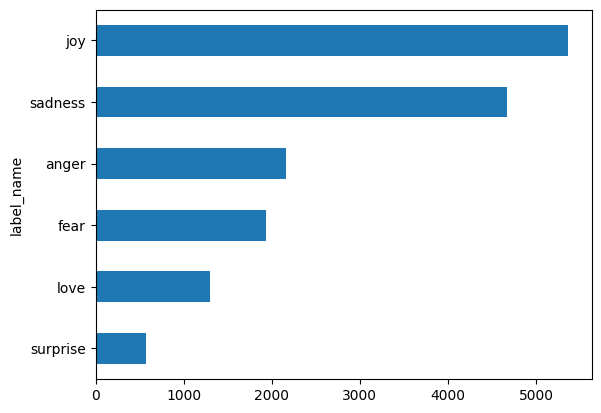

In [5]:
labelCount = data['label_name'].value_counts(ascending=True)
labelCount.plot.barh()
plt.show()

<Axes: title={'center': 'Words per Tweet'}, xlabel='label_name'>

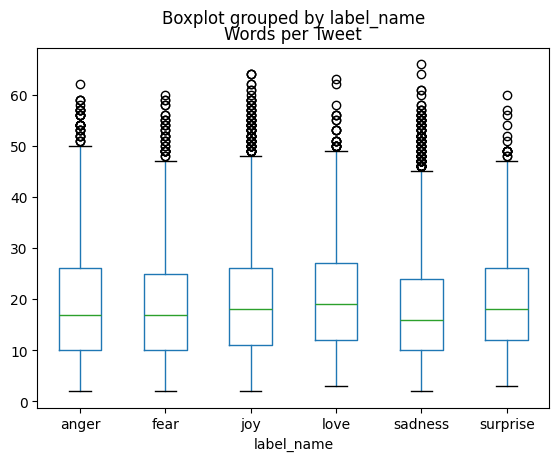

In [6]:
data['Words per Tweet'] = data['text'].str.split().apply(len)
data.boxplot("Words per Tweet", by="label_name", grid=False)

#Creating train , text and split

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, stratify = data['label_name'])
test, val = train_test_split(test, test_size=1/3, stratify = test['label_name'])

train.shape, test.shape, val.shape

((11200, 4), (3200, 4), (1600, 4))

In [8]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        'train': Dataset.from_pandas(train, preserve_index=False),
        'test': Dataset.from_pandas(train, preserve_index=False),
        'val': Dataset.from_pandas(train, preserve_index=False),

    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    val: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
})

#Creating Tokens(Tokenization)


In [9]:
dataset['train'][1], dataset['train'][3]

({'text': 'im feeling resolved',
  'label': 1,
  'label_name': 'joy',
  'Words per Tweet': 3},
 {'text': 'i feel very blessed to have a new team of doctors that are by my side and listen',
  'label': 2,
  'label_name': 'love',
  'Words per Tweet': 18})

In [10]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [11]:
def tokenize(batch):
  tok = tokenizer(batch['text'], padding=True, truncation=True)
  return tok

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1996, 6715, 1997, 1037, 2767, 2040, 2001, 2730, 1999, 1037, 2482, 4926, 2016, 2001, 1997, 2026, 2219, 2287, 102], [101, 10047, 3110, 10395, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [12]:
dataToken = dataset.map(tokenize, batched=True, batch_size=None)
dataToken

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    val: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
})

##Mapping label and labelid

In [13]:
label2id = {x['label_name'] : x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

In [14]:
label2id, id2label

({'sadness': 0, 'joy': 1, 'love': 2, 'fear': 4, 'anger': 3, 'surprise': 5},
 {0: 'sadness', 1: 'joy', 2: 'love', 4: 'fear', 3: 'anger', 5: 'surprise'})

#Importing model

In [15]:
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoModel
import torch

In [16]:
model = AutoModel.from_pretrained(model_checkpoint)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [17]:
nofLabels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_checkpoint, nums_labels=nofLabels, id2label=id2label, label2id=label2id)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Building training arguments

In [25]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "bert_base_train_dir"

training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    report_to="none"

)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#Building compute metrics

In [26]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def eval_compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)

  return accuracy.compute(predictions=predictions, references=labels)

In [27]:
from sklearn.metrics import f1_score, accuracy_score

def sk_compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)

  return {"accuracy": acc, "f1": f1}

#Building Model Trainer

In [28]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = sk_compute_metrics,
    train_dataset = dataToken['train'],
    eval_dataset = dataToken['val'],
    tokenizer = tokenizer
)

<ipython-input-28-b1419a925081>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.458831,0.871875,0.866217
2,No log,0.240150,0.929107,0.928882


TrainOutput(global_step=350, training_loss=0.7278749302455357, metrics={'train_runtime': 448.0267, 'train_samples_per_second': 49.997, 'train_steps_per_second': 0.781, 'total_flos': 1001502421516800.0, 'train_loss': 0.7278749302455357, 'epoch': 2.0})

#Evaluating Model

In [31]:
OutPreds =  trainer.predict(dataToken['test'])
OutPreds.metrics

{'test_loss': 0.24014973640441895,
 'test_accuracy': 0.9291071428571429,
 'test_f1': 0.9288821361598293,
 'test_runtime': 61.2315,
 'test_samples_per_second': 182.912,
 'test_steps_per_second': 2.858}

In [32]:
y_pred = np.argmax(OutPreds.predictions, axis=1)
y_true = dataToken['test'][:]['label']

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3266
           1       0.95      0.94      0.95      3754
           2       0.81      0.84      0.83       913
           3       0.93      0.95      0.94      1511
           4       0.89      0.92      0.90      1356
           5       0.88      0.72      0.79       400

    accuracy                           0.93     11200
   macro avg       0.90      0.89      0.90     11200
weighted avg       0.93      0.93      0.93     11200



#Plotting confusion matrix

<Axes: >

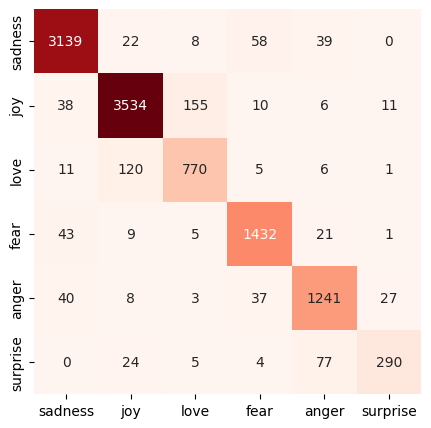

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
plt.ylabel('Actual')
plt.xlabel('Predicted')
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')

#Building prediction function and storing model

In [38]:
text = "Finetuning BERT for multi class sentiment classification on twitter tweets is successfully completed"

def predict(text):
  EncodedInput = tokenizer(text, return_tensors='pt').to(device)

  with torch.no_grad():
    output = model(**EncodedInput)

  logits = output.logits
  pred = torch.argmax(logits, dim=1).item()

  return id2label[pred]


In [40]:
trainer.save_model("bert-base-uncased-multi-sentiment")

#Using pipiline method for prediction

In [43]:
from transformers import pipeline
classifier = pipeline("text-classification", model='bert-base-uncased-multi-sentiment')

classifier([text, 'Hi, where are you?', "Hey, I love you"])

Device set to use cuda:0


[{'label': 'joy', 'score': 0.9499704837799072},
 {'label': 'joy', 'score': 0.3332422375679016},
 {'label': 'love', 'score': 0.5104306936264038}]